In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [2]:
"""
Following this tutorial: https://towardsdatascience.com/implement-a-gaussian-process-from-scratch-2a074a470bce

Create the GP class
""" 
class GP:
    def __init__(self, n_restarts, optimizer):
        """ Initialize a GP model
        
        Parameters
        n_restarts: number of restarts of the local optimzer
        optimizer: algorithm of local optimization
        """
        self.n_restarts = n_restarts
        self.optimizer = optimizer
        
    def compute_corr(self, X1, X2, theta):
        """ Computes the correlation matrix
        
        Parameters
        X1, X2: 2d arrays (n_smaples, n_features) (?)
        theta: array, correlation lengths for different dimensions (smaller theta = more correlated)
        
        Output
        K: correlation matrix
        """
        K = np.zeros((X1.shape[0], X2.shape[0]))
        for i in range(X1.shape[0]): #for each of the rows in matrix X1
            K[i, :] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))
        return K
    
    def Neglikelihood(self, theta):
        """Negative likelihood function
        
        Input
        -----
        theta: array, logarithm of the correlation legnths for different dimensions
        
        Output
        ------
        LnLike: likelihood value"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances
        one = np.ones((n,1))      # Vector of ones
        
        # Construct correlation matrix
        K = self.compute_corr(self.X, self.X, theta) + np.eye(n)*1e-10
        inv_K = np.linalg.inv(K)   # Inverse of correlation matrix
        
        # Mean estimation
        mu = (one.T @ inv_K @ self.y)/ (one.T @ inv_K @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ inv_K @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetK = np.linalg.det(K)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetK)
        
        # Update attributes
        self.K, self.inv_K , self.mu, self.SigmaSqr = K, inv_K, mu, SigmaSqr
        
        return -LnLike.flatten()
    

    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        lb, ub = -3, 2
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        
        # Scale random samples to the given bounds 
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))
        
        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros((self.n_restarts, 1))
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood, initial_points[i,:], method=self.optimizer,
                bounds=bnds)
            opt_para[i,:] = res.x
            opt_func[i,:] = res.fun
        
        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]
        
        # Update attributes
        self.NegLnlike = self.Neglikelihood(self.theta)
        
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""
        
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        k = self.compute_corr(self.X, X_test, 10**self.theta)
        
        # Mean prediction
        f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ self.inv_K @ k))
        
        return f.flatten(), SSqr.flatten()
    
    def score(self, X_test, y_test):
        """Calculate root mean squared error
        
        Input
        -----
        X_test: test set, array of shape (n_samples, n_features)
        y_test: test labels, array of shape (n_samples, )
        
        Output
        ------
        RMSE: the root mean square error"""
        
        y_pred, SSqr = self.predict(X_test)
        RMSE = np.sqrt(np.mean((y_pred-y_test)**2))
        
        return RMSE


In [3]:
"""
Generates Test points 
"""
def fn(X):
    Y = (X*6-2)**2*np.sin(X*12-4)
    return Y

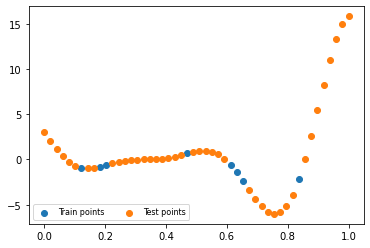

In [4]:
# Our mock data- an array of evenly spaced points from 0 to 1
x_data = np.linspace(0.0, 1, 50)

# Randomly choose a few points for training, the rest for testing
x_train = np.random.choice(x_data, 8, False).reshape(-1, 1)
y_train = fn(x_train)

x_test = np.setdiff1d(x_data, x_train).reshape(-1, 1)
y_test = fn(x_test)

# Graph Our training and testing points
train_plt = plt.scatter(x_train, y_train)
test_plt = plt.scatter(x_test, y_test)
plt.legend((train_plt, test_plt),
           ('Train points', 'Test points'),
           loc='lower left',
           scatterpoints=1,
           ncol=3,
           fontsize=8)

plt.show()


In [8]:
# GP model training
gp_mod = GP(n_restarts=10, optimizer='L-BFGS-B')
gp_mod.fit(x_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = gp_mod.predict(x_test)
print(y_pred_SSqr)

[1.90646830e+00 1.47154451e+00 9.58762485e-01 4.86158827e-01
 1.65875905e-01 2.57585556e-02 3.52623138e-03 1.69119233e-03
 7.67772131e-03 7.49064450e-02 2.82814090e-01 6.59529180e-01
 1.12648712e+00 1.53376436e+00 1.74177899e+00 1.67934745e+00
 1.36149792e+00 8.86694118e-01 4.13434019e-01 9.67072894e-02
 5.47827371e-02 1.24317027e-01 1.22825548e-01 6.76750223e-02
 1.92619362e-02 1.80644034e-03 2.30043215e-03 2.84617218e-02
 1.20969459e-01 2.86818585e-01 4.45177997e-01 4.73753542e-01
 3.28573282e-01 1.09699494e-01 1.35482422e-01 5.20553832e-01
 1.04381177e+00 1.56028259e+00 1.96828643e+00 2.23661108e+00
 2.38646438e+00 2.45834263e+00]


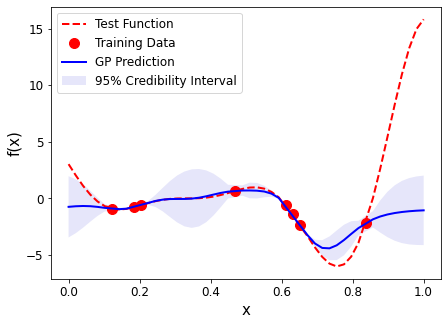

In [6]:
# Plot test function, training data and GP prediction
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(x_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(x_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(x_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
# ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});